<a href="https://colab.research.google.com/github/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15_Network_Packet_Classification_PyTorch_Categorical_Variational_AutoEncoder_with_Gumbel_Softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import scipy

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import * 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

import torch
import torch.nn as nn 


# import warnings
# warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

DLed = False

In [2]:
if not DLed:
    train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
    test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
    DLed = True
    
combined_data = pd.concat([train, test]).drop(['id','label'],1)
combined_data.shape
combined_data.head(5)

(257673, 43)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal


In [3]:
tmp = train.where(train['attack_cat'] == "Normal").dropna()
print('Train ', round(len(tmp['attack_cat'])/len(train['attack_cat']),5))

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print('Test ', round(len(tmp['attack_cat'])/len(test['attack_cat']),5))

# del train, test

Train  0.31938
Test  0.4494


In [4]:
le = LabelEncoder()

vector = combined_data['attack_cat']
print("attack cats:", list(set(list(vector)))) # use print to make it print on single line 

combined_data['attack_cat'] = le.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

print('\nDescribing attack types: ')

print("mode", vector.mode())
print(f"mode {np.sum(combined_data['attack_cat'].values==6)/vector.shape[0]:.2f}%") # alt numerator:  len(np.where(combined_data['attack_cat'].values==6)[0])

print("looks like 6 is 'normal', but its not that common")

attack cats: ['Worms', 'Shellcode', 'Analysis', 'Backdoor', 'DoS', 'Fuzzers', 'Normal', 'Exploits', 'Generic', 'Reconnaissance']

Describing attack types: 
mode 0    Normal
dtype: object
mode 0.36%
looks like 6 is 'normal', but its not that common


In [5]:
import collections
from tabulate import tabulate

counter = collections.Counter(vector)  
print(tabulate(counter.most_common(),headers = ['Type','Occurences']))

Type              Occurences
--------------  ------------
Normal                 93000
Generic                58871
Exploits               44525
Fuzzers                24246
DoS                    16353
Reconnaissance         13987
Analysis                2677
Backdoor                2329
Shellcode               1511
Worms                    174


In [6]:
COPY = combined_data.copy(deep=True)

In [7]:
combined_data = COPY
assert COPY.shape == combined_data.shape

lowSTD = list(combined_data.std().to_frame().nsmallest(7, columns=0).index)
lowCORR = list(combined_data.corr().abs().sort_values('attack_cat')['attack_cat'].nsmallest(7).index) # .where(lambda x: x < 0.005).dropna()

In [8]:
exclude = list(lowCORR + lowSTD)
if 'attack_cat' in exclude:
  exclude.remove('attack_cat')

print('shape before:', combined_data.shape)
print('replace the following with their PCA(3) -', exclude)

# dim_reduct = SparsePCA(10, n_jobs = -1).fit_transform(combined_data)
# dim_reduct = TruncatedSVD(4).fit_transform(combined_data[exclude])
pca = PCA(3)
dim_reduct = pca.fit_transform(combined_data[exclude])

print("explained_variance_ratio_ is", sum(pca.explained_variance_ratio_))

combined_data.drop(exclude,axis=1,inplace=True)

dim_reduction = pd.DataFrame(dim_reduct)
combined_data = combined_data.join(dim_reduction)

print('shape after:', combined_data.shape)


shape before: (257673, 43)
replace the following with their PCA(3) - ['sjit', 'response_body_len', 'djit', 'dinpkt', 'dbytes', 'spkts', 'dloss', 'ackdat', 'synack', 'tcprtt', 'is_ftp_login', 'ct_ftp_cmd', 'is_sm_ips_ports', 'ct_flw_http_mthd']
explained_variance_ratio_ is 0.999538282884239
shape after: (257673, 32)


In [9]:
print('combined_data.dur is scaled up by 10,000')
combined_data['dur'] = 10000*combined_data['dur']
combined_data.head()

combined_data.dur is scaled up by 10,000


,dur,proto,service,state,dpkts,sbytes,rate,sttl,dttl,sload,dload,sloss,sinpkt,swin,stcpb,dtcpb,dwin,smean,dmean,trans_depth,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,attack_cat,0,1,2
0,1214.78,113,0,4,4,258,74.087490,252,254,1.415894e+04,8495.365234,0,24.295600,255,621772692,2202533631,255,43,43,0,1,0,1,1,1,1,1,1,6,-14339.811230,-5427.117131,363.455824
0,0.11,119,0,5,0,496,90909.090200,254,0,1.803636e+08,0.000000,0,0.011000,0,0,0,0,248,0,0,2,2,1,1,1,2,1,2,6,-14339.811230,-5427.117131,363.455824
1,6499.02,113,0,4,38,734,78.473372,62,252,8.395112e+03,503571.312500,2,49.915000,255,1417884146,3077387971,255,52,1106,0,43,1,1,1,1,2,1,6,6,26947.677836,-5283.049895,-6435.428556
1,0.08,119,0,5,0,1762,125000.000300,254,0,8.810000e+08,0.000000,0,0.008000,0,0,0,0,881,0,0,2,2,1,1,1,2,1,2,6,26947.677836,-5283.049895,-6435.428556
2,16231.29,113,0,4,16,364,14.170161,62,252,1.572272e+03,60929.230470,1,231.875571,255,2116150707,2963114973,255,46,824,0,7,1,2,1,1,3,2,6,6,-1508.847447,12187.598091,-1747.491867


In [10]:
print('before:', combined_data.shape)
data_x = combined_data.drop(['attack_cat'], axis=1) # droped label
data_y = combined_data['attack_cat']
data_x.shape
data_y.shape

data_x = data_x.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# data_x = MinMaxScaler().fit_transform(data_x) # better for VotingClassifier
# data_x = StandardScaler().fit_transform(data_x)

before: (257673, 32)


(257673, 31)

(257673,)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.50, random_state=42) # TODO

In [12]:
DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=50, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=75, criterion='gini', max_features='auto', bootstrap=False)

eclf = VotingClassifier(estimators=[('lr', DTC), ('rf', RFC),('et',ETC)], voting='hard') 
for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
    _ = clf.fit(X_train, y_train)
    pred = clf.score(X_test,y_test)
    print("Acc: %0.7f [%s]" % (pred,label))

Acc: 0.8102641 [DecisionTreeClassifier]
Acc: 0.8337279 [RandomForestClassifier]
Acc: 0.8280385 [ExtraTreesClassifier]
Acc: 0.8316477 [Ensemble]


In [13]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA,TruncatedSVD,PCA
from sklearn.svm import LinearSVC

rfe = RFE(DecisionTreeClassifier(), 10).fit(X_train,y_train)
desiredIndices = np.where(rfe.support_==True)[0]

X_train, X_test = pd.DataFrame(X_train),  pd.DataFrame(X_test)

whitelist = X_train.columns.values[desiredIndices]
X_train_RFE, X_test_RFE = X_train[whitelist],X_test[whitelist]

DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=50, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=75, criterion='gini', max_features='auto', bootstrap=False)

# X_train.shape
# X_train_RFE.shape
# y_train.shape

# print()
# X_test.shape
# X_test_RFE.shape
# y_test.shape

eclf = VotingClassifier(estimators=[('lr', DTC), ('rf', RFC),('et',ETC)], voting='hard') 
for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
    _ = clf.fit(X_train_RFE, y_train)
    pred = clf.score(X_test_RFE, y_test)
    print("Acc: %0.7f [%s]" % (pred,label))

Acc: 0.8058787 [DecisionTreeClassifier]
Acc: 0.8269131 [RandomForestClassifier]
Acc: 0.8237696 [ExtraTreesClassifier]
Acc: 0.8261059 [Ensemble]


In [14]:
X_train_RFE.shape
set(y_train)

# X_train_RFE.dtype = np.int


# torch.as_tensor(X_train_RFE_vals[i].astype('double'),dtype=torch.double)

(128836, 10)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Neural network


## feed forward

*Categorical Variational AutoEncoder with Gumbel-Softmax* at end


In [15]:
# RFE on 80% train 
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.80, random_state=42) 

rfe = RFE(DecisionTreeClassifier(), 10).fit(X_train,y_train)
desiredIndices = np.where(rfe.support_==True)[0]

X_train, X_test = pd.DataFrame(X_train),  pd.DataFrame(X_test)

whitelist = X_train.columns.values[desiredIndices]
X_train_RFE, X_test_RFE = X_train[whitelist], X_test[whitelist]

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

input_size = 10
hidden_size = 64 
hidden_size_2 = 64
num_classes = 10

num_epochs = 40
batch_size = 32
learning_rate = 0.001

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size # ?? 
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size_2)  
        self.l3 = nn.Linear(hidden_size_2, num_classes)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        # no activation and no softmax at the end
        return out

In [17]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(X_train)

X_train_RFE_vals= X_train_RFE.values
y_train_vals = y_train.values

for epoch in range(num_epochs):
    # for i in range(len(X_train_RFE_vals)//100 + 1): #, batch_size
    for i in range(0, X_train_RFE_vals.shape[0], batch_size):


        x = torch.as_tensor(X_train_RFE_vals[i:i+batch_size], dtype=torch.float).to(device)
        y = torch.as_tensor(y_train_vals[i:i+batch_size], dtype=torch.long).to(device)

        # x.type()
        # y.type()
        
        outputs = model(x)
        loss = criterion(outputs, y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [10/40], Step [51521/51534], Loss: 0.5041
Epoch [20/40], Step [51521/51534], Loss: 0.4103
Epoch [30/40], Step [51521/51534], Loss: 0.3893
Epoch [40/40], Step [51521/51534], Loss: 0.3890


In [18]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
X_test_RFE_vals= X_test_RFE.values
y_test_vals = y_test.values
with torch.no_grad():
    n_correct = 0
    n_samples = 0 
    # for i in range(len(X_train_RFE_vals)//100 + 1):   
    for i in range(0, X_test_RFE_vals.shape[0], batch_size):
        x = torch.as_tensor(X_test_RFE_vals[i:i+batch_size], dtype=torch.float).to(device)
        y = torch.as_tensor(y_test_vals[i:i+batch_size], dtype=torch.long).to(device)
        
        outputs = model(x)
        if len(outputs.data) > 0:
          # max returns (value ,index)
          _, predicted = torch.max(outputs.data, dim=1)
          n_samples += y.size(0)
          n_correct += (predicted == y).sum().item()
        else:
          print("what???")
          print(x, outputs.data)
    acc = 100.0 * n_correct / (n_samples+1)
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 78.81439798195402 %


##  Categorical Variational AutoEncoder with Gumbel-Softmax

* https://github.com/YongfeiYan/Gumbel_Softmax_VAE/blob/master/gumbel_softmax_vae.py

* https://github.com/shaabhishek/gumbel-softmax-pytorch/blob/master/Categorical%20VAE.ipynb


* https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
  * https://blog.evjang.com/2016/11/tutorial-categorical-variational.html



In [19]:
import copy
device = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# RFE on 80% train 
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.80, random_state=42) 

rfe = RFE(DecisionTreeClassifier(), 10).fit(X_train,y_train)

whitelist = X_train.columns.values[np.where(rfe.support_==True)[0]]
X_train_RFE, X_test_RFE = pd.DataFrame(X_train)[whitelist], pd.DataFrame(X_test)[whitelist]

X_train = torch.as_tensor(X_train_RFE.to_numpy(), dtype=torch.float).to(device)
X_test  = torch.as_tensor(X_test_RFE.to_numpy(), dtype=torch.float).to(device)

In [20]:
import torch
import torch.nn.functional as F

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).to(device) # U is a unif.. waht ever that means.. 
    # eps = eps.to(device)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)


def gumbel_softmax(logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    
    if not hard:
        return y.view(-1, latent_dim * categorical_dim)

    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y
    return y_hard.view(-1, latent_dim * categorical_dim)


class VAE_gumbel(nn.Module):
    def __init__(self, temp, shape):
        super(VAE_gumbel, self).__init__()
        print("shape:", shape)

        self.batch_size = shape[0]
        self.dim = shape[1]
        self.mid = 200 
        self.inner = 150

        self.fc1 = nn.Linear(self.dim * self.batch_size, self.mid)
        self.fc2 = nn.Linear(self.mid, self.inner)
        self.fc3 = nn.Linear(self.inner , latent_dim * categorical_dim)

        self.fc4 = nn.Linear(latent_dim * categorical_dim, self.inner)
        self.fc5 = nn.Linear(self.inner, self.mid)
        self.fc6 = nn.Linear(self.mid, self.dim * self.batch_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decode(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, x, temp, hard):
        # print('x', x.size())
        q = self.encode(x.reshape(-1, self.dim * self.batch_size))
        q_y = q.view(q.size(0), latent_dim, categorical_dim)
        z = gumbel_softmax(q_y, temp, hard)

        # decode(gumbel_softmax(q_y)), softmax(q_y)
        return self.decode(z), F.softmax(q_y, dim=-1).reshape(*q.size()) 

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, qy):
    # print(recon_x.size()) # torch.Size([1, 640])
    # print(x.size())       # torch.Size([64, 10])   # x.size()[0] * x.size()[1]

    BCE = F.binary_cross_entropy(recon_x, x.reshape(-1, x.size()[0] * x.size()[1]), size_average=False) / x.shape[0]

    log_ratio = torch.log(qy * categorical_dim + 1e-20)
    KLD = torch.sum(qy * log_ratio, dim=-1).mean()

    return BCE + KLD

### Experiment for autoencoder
> keep only the features that have a "huge" difference between normal and attack  

VotingClassifier 83% -> 76% acc

AutoEncoder 88.3%-> 82.1%

In [21]:
normal = combined_data[combined_data['attack_cat']==6].drop(['attack_cat'], axis=1).apply(lambda x: (x - x.min()) / (x.max() - x.min()))
attack = combined_data[combined_data['attack_cat']!=6].drop(['attack_cat'], axis=1).apply(lambda x: (x - x.min()) / (x.max() - x.min()))

split = int(len(normal)*0.9)

normal_train = normal.values[:split]
normal_test = normal.values[split:]

X_train = torch.as_tensor(normal_train, dtype=torch.float).to(device)
X_test = torch.as_tensor(normal_test, dtype=torch.float).to(device)

normal_tensor = torch.as_tensor(normal.values, dtype=torch.float).to(device)
attack_tensor = torch.as_tensor(attack.values, dtype=torch.float).to(device)

print("attack_tensor.shape: ", attack.values.shape)
print("normal.shape: ", normal.values.shape)
print("X_train.shape: ", X_train.size())
print("X_test.shape: ", X_test.size())

attack_tensor.shape:  (164673, 31)
normal.shape:  (93000, 31)
X_train.shape:  torch.Size([83700, 31])
X_test.shape:  torch.Size([9300, 31])


In [31]:
def train(epoch, temp=1, hard=False):
    model.train()
    # train_loss = 0

    for i in range(0, X_train.shape[0], batch_size):
        if (i+batch_size > X_train.shape[0]):
            break # avoid the issue of odd batch size...
        data = X_train[i:i+batch_size] #.to(device)

        # decode(gumbel_softmax(q_y)), softmax(q_y)
        recon_batch, qy = model(data, temp, hard)

        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, qy)
        loss.backward()
        # train_loss += loss.item() * len(data)
        optimizer.step()
        
        if i % batch_size == 1:
          temp = np.maximum(temp * np.exp(-ANNEAL_RATE * i), temp_min)
        
        if i % 3000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(X_train),
                       100. * i / len(X_train),
                       loss.item()))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, loss.item() ))


def test(epoch, best_loss, temp=1, hard=False):
    model.eval()
    test_loss = []

    for i in range(0, X_test.shape[0], batch_size):
        if (i+batch_size > X_test.shape[0]):
            break # avoid the issue of odd batch size...
        data = X_test[i:i+batch_size] # .to(device)
        recon_batch, qy = model(data, temp, hard)
        _loss = loss_function(recon_batch, data, qy).item()
        test_loss.append(_loss)
        if i % 100 == 1:
          temp = np.maximum(temp * np.exp(-ANNEAL_RATE * i), temp_min)

    val_loss = sum(test_loss)/len(test_loss)
    print(f'====> Test set loss: {val_loss:.4f}')
    scheduler.step(val_loss) # ReduceLROnPlateau

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      print(f"Best loss is {val_loss}, weights saved*")
    return best_loss

latent_dim = 10 # was 30 
categorical_dim = 10 # was 10  # one-of-K vector

temp = 1
temp_min = 0.5
ANNEAL_RATE = 0.00003

epochs = 16
batch_size = 36

model = VAE_gumbel(temp, (batch_size, X_train.shape[1])) # default=1.0, metavar='S', help='tau(temperature) (default: 1.0)')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0009) # 1e-3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 100000000000.0 

for epoch in range(1, epochs + 1):
    train(epoch)
    best_loss = test(epoch, best_loss)

    M = 64 * latent_dim
    np_y = np.zeros((M, categorical_dim), dtype=np.float32)
    np_y[range(M), np.random.choice(categorical_dim, M)] = 1
    np_y = np.reshape(np_y, [M // latent_dim, latent_dim, categorical_dim])
    sample = torch.from_numpy(np_y).view(M // latent_dim, latent_dim * categorical_dim)
    sample = sample.to(device)
    sample = model.decode(sample).cpu()
    print(sample.size())

model.load_state_dict(best_model_wts)
# torch.save(model, 'model.pth')

shape: (36, 31)
Train Epoch: 1 [0/83700 (0%)]	Loss: 21.525465


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [324000/83700 (11%)]	Loss: 7.878410
Train Epoch: 1 [648000/83700 (22%)]	Loss: 8.001693
Train Epoch: 1 [972000/83700 (32%)]	Loss: 7.939018
Train Epoch: 1 [1296000/83700 (43%)]	Loss: 8.209831
Train Epoch: 1 [1620000/83700 (54%)]	Loss: 8.280560
Train Epoch: 1 [1944000/83700 (65%)]	Loss: 11.108716
Train Epoch: 1 [2268000/83700 (75%)]	Loss: 8.660810
Train Epoch: 1 [2592000/83700 (86%)]	Loss: 8.643674
Train Epoch: 1 [2916000/83700 (97%)]	Loss: 8.244834
====> Epoch: 1 Average loss: 8.1323
====> Test set loss: 10.8159
Best loss is 10.815860598586326, weights saved*
torch.Size([64, 1116])
Train Epoch: 2 [0/83700 (0%)]	Loss: 10.578753
Train Epoch: 2 [324000/83700 (11%)]	Loss: 7.879595
Train Epoch: 2 [648000/83700 (22%)]	Loss: 8.005692
Train Epoch: 2 [972000/83700 (32%)]	Loss: 7.939285
Train Epoch: 2 [1296000/83700 (43%)]	Loss: 8.199089
Train Epoch: 2 [1620000/83700 (54%)]	Loss: 8.288415
Train Epoch: 2 [1944000/83700 (65%)]	Loss: 11.254662
Train Epoch: 2 [2268000/83700 (75%)]	Loss:

<All keys matched successfully>

In [32]:
def predict(dataset, temp=1, hard=False):
    model.eval()
    test_loss = []

    # for i, (data, _) in enumerate(test_loader):
    for i in range(0, dataset.shape[0], batch_size):
        if (i+batch_size > dataset.shape[0]):
            break # avoid the issue of odd batch size...
            
        data = dataset[i:i+batch_size] # .to(device)
        recon_batch, qy = model(data, temp, hard)
        test_loss.append(loss_function(recon_batch, data, qy).item() * len(data))
        # if i % 100 == 1:
        temp = np.maximum(temp * np.exp(-ANNEAL_RATE * i), temp_min)

    print(f'====> Dataset set loss: {sum(test_loss)/len(test_loss):.4f}')
    return test_loss

In [33]:
print(X_train.size())
losses_train  = predict(X_train)
losses_test   = predict(X_test)
losses_attack = predict(attack_tensor)
losses_normal = predict(normal_tensor)

torch.Size([83700, 31])


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Dataset set loss: 774.5191
====> Dataset set loss: 774.9292
====> Dataset set loss: 774.9846
====> Dataset set loss: 774.5649


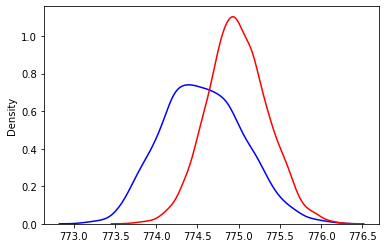

In [34]:
import seaborn as sns
# sns.distplot(losses, bins=50, kde=False);
# sns.kdeplot(losses);
# plt.hist(losses_train, bins=50);
# plt.hist(losses_test, bins=50);
# plt.hist(losses_attack, bins=50);
# plt.hist(losses_normal, bins=50);

sns.kdeplot(losses_normal, color='b');
sns.kdeplot(losses_attack, color='r');
# sns.distplot(losses_normal, bins=50, kde=True);
# sns.distplot(losses_attack, bins=50, kde=True);

## NOTE

SET `lower` & `upper` to an eyeball approximationof the **BLUE** peak
> I'm my other notebook, this with with the red peak

In [36]:
# Brute force compute cutoffs that maximize accuracy  
lower = 660 # select the red peak
upper = 774.75

# lower_list = [lower + round(-7+(0.5*i), 2) for i in range(31)] # [lower-1,lower-0.5,lower,lower+0.5,lower+1]
# upper_list = [upper + round(-7+(0.5*i), 2) for i in range(31)] # [upper-1,upper-0.5,upper,upper+0.5,upper+1]
lower_list = [lower + round(-1+(0.05*i), 2) for i in range(31)] # [lower-1,lower-0.5,lower,lower+0.5,lower+1]
upper_list = [upper + round(-1+(0.05*i), 2) for i in range(31)] # [upper-1,upper-0.5,upper,upper+0.5,upper+1]
ls_1 = []
ls_2 = []
print('lower_list', lower_list[0], 'to', lower_list[-1])

for i in range(len(lower_list)):
  lower = lower_list[i]
  for i in range(len(upper_list)):
    upper = upper_list[i]

    all_attack = np.array(losses_attack)
    FP = all_attack[(all_attack > lower) & (all_attack < upper)]
    TN = all_attack[(all_attack <= lower) | (all_attack >= upper)]

    all_normal = np.array(losses_normal)
    TP = all_normal[(all_normal > lower) & (all_normal < upper)]
    FN = all_normal[(all_normal <= lower) | (all_normal >= upper)]

    ls_1.append((len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN)))
    ls_2.append((lower, upper))

lower_list 659.0 to 660.5


In [37]:
idx = np.argmax(np.array(ls_1))
# print(ls_1[idx])
# print(ls_2[idx])
lower = ls_2[idx][0]
upper = ls_2[idx][1]

all_attack = np.array(losses_attack)
FP = all_attack[(all_attack > lower) & (all_attack < upper)]
TN = all_attack[(all_attack <= lower) | (all_attack >= upper)]

all_normal = np.array(losses_normal)
TP = all_normal[(all_normal > lower) & (all_normal < upper)]
FN = all_normal[(all_normal <= lower) | (all_normal >= upper)]

ls_1.append((len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN)))
ls_2.append((lower, upper))

print(f'TP: {len(TP)}')
print(f'FN: {len(FN)}')
print(f'TPR: {len(TP)/(len(TP)+len(FN))}')

print(f'TN: {len(TN)}')
print(f'FP: {len(FP)}')
print(f'TNR: {len(TN)/(len(TN)+len(FP))}')

print(f'Accuracy : {(len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))}')
# https://en.wikipedia.org/wiki/Precision_and_recall#Imbalanced_data

TP: 1104
FN: 1479
TPR: 0.4274099883855981
TN: 4263
FP: 311
TNR: 0.9320069960647136
Accuracy : 0.7498952074891715


In [28]:
## Best is 81% Acc